In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
from torchvision.datasets import CocoDetection
from pycocotools.coco import COCO
from torch.utils.data import DataLoader
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.ops import nms
from PIL import Image

In [ ]:
class ReceptiveFieldBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale=1):
        super(ReceptiveFieldBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.scale = scale

        # Branch 1
        self.branch1_conv1 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.branch1_conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, dilation=1)

        # Branch 2
        self.branch2_conv1 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.branch2_conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.branch2_conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, dilation=3)

        # Branch 3
        self.branch3_conv1 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.branch3_conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=2)
        self.branch3_conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, dilation=5)

        # Final 1x1 convolution after concatenation
        self.final_conv = nn.Conv2d(3 * out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)

        # Branch 1
        branch1 = self.branch1_conv1(x)
        branch1 = self.branch1_conv2(branch1)

        # Branch 2
        branch2 = self.branch2_conv1(x)
        branch2 = self.branch2_conv2(branch2)
        branch2 = self.branch2_conv3(branch2)

        # Branch 3
        branch3 = self.branch3_conv1(x)
        branch3 = self.branch3_conv2(branch3)
        branch3 = self.branch3_conv3(branch3)

        # Ensure that the outputs have the same spatial dimensions
        min_height = min(branch1.shape[2], branch2.shape[2], branch3.shape[2])
        min_width = min(branch1.shape[3], branch2.shape[3], branch3.shape[3])

        branch1 = branch1[:, :, :min_height, :min_width]
        branch2 = branch2[:, :, :min_height, :min_width]
        branch3 = branch3[:, :, :min_height, :min_width]

        # Concatenate branches
        out = torch.cat([branch1, branch2, branch3], dim=1)

        # Apply 1x1 convolution
        out = self.final_conv(out)

        # Combine with the input using the scale factor
        #out = x + self.scale * out

        return F.relu(out)


In [ ]:
class CSP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CSP, self).__init__()

        # Path 1: Single 3x3 convolution with batch normalization
        self.path1_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        # Path 2: 3x3 conv1 -> 3x3 conv2 -> 3x3 conv1 + 3x3 conv2 -> 3x3 conv3 with batch normalization
        self.path2_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.path2_conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.path2_conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        # Path 1
        path1_output = F.relu(self.path1_conv(x))

        # Path 2
        path2_output1 = F.relu(self.path2_conv1(x))
        path2_output2 = F.relu(self.path2_conv2(path2_output1))
        path2_combined = path2_output1 + path2_output2
        path2_output = F.relu(self.path2_conv3(path2_combined))

        # Concatenate the outputs of Path 1 and Path 2
        final_output = torch.cat([path1_output, path2_output], dim=1)

        return final_output


In [ ]:
class TwoBranchNetwork(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TwoBranchNetwork, self).__init__()

        # Branch 1: 3x3 conv1 -> 1x1 conv1 -> 3x3 conv2 -> 1x1 conv3
        self.branch1_conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch1_conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.branch1_conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.branch1_conv4 = nn.Conv2d(out_channels, out_channels, kernel_size=1)

        # Branch 2: 3x3 conv3 -> 1x1 conv4
        self.branch2_conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.branch2_conv4 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.branch2_conv5 = nn.Conv2d(out_channels, out_channels, kernel_size=1)

        # Upsampling layer
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Branch 1
        branch1_output = F.relu(self.branch1_conv1(x))
        branch1_output = F.relu(self.branch1_conv2(branch1_output))
        branch1_output = F.relu(self.branch1_conv3(branch1_output))
        #branch1_output = F.relu(self.branch1_conv4(branch1_output))
        output1 = F.relu(self.branch1_conv4(branch1_output))

        # Branch 2
        branch2_output = F.relu(self.branch1_conv1(x))
        branch2_output = F.relu(self.branch1_conv2(branch2_output))
        branch2_output = F.relu(self.branch2_conv3(branch1_output))
        branch2_output = self.upsample(branch2_output)
        branch2_output = F.relu(self.branch2_conv4(branch2_output))
        output2 = F.relu(self.branch2_conv5(branch2_output))

        return output1, output2

In [ ]:
class Model(nn.Module):
    def __init__(self, RFB, CSPnet1,CSPnet2,TwoBranch,Classification,BBoxRegression):
        super(Model, self).__init__()
        self.RFB = RFB
        self.CSPnet1 = CSPnet1
        self.CSPnet2 = CSPnet2
        self.TwoBranch = TwoBranch
        self.Classification = Classification
        self.BBoxRegression = BBoxRegression

    def forward(self, x):
        rfb_output = self.RFB(x)
        #print(rfb_output.shape)
        csp_output1 = self.CSPnet1(rfb_output)
        #print(csp_output1.shape)
        pooled_output1 = F.max_pool2d(csp_output1, kernel_size=2, stride=2)
        #print(pooled_output1.shape)
        csp_output2 = self.CSPnet2(pooled_output1)
        #print(csp_output2.shape)
        pooled_output2 = F.max_pool2d(csp_output2, kernel_size=2, stride=2)
        #print(pooled_output2.shape)
        two_branch_output = self.TwoBranch(pooled_output2)
        classification_output = self.Classification(two_branch_output[0])
        #print(classification_output.shape)
        bbox_regression_output = self.BBoxRegression(two_branch_output[1])
        #print(bbox_regression_output.shape)
        return classification_output, bbox_regression_output


In [ ]:
class ClassificationModule(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ClassificationModule, self).__init__()
        # Assuming your input size is [batch_size, in_channels, height, width]
        self.fc = nn.Linear(in_channels * 54 * 54, num_classes)

    def forward(self, x):
        # Flatten the input tensor before passing it through the fully connected layer
        x = x.view(x.size(0), -1)
        return self.fc(x)


class BoundingBoxRegressionModule(nn.Module):
    def __init__(self, in_channels, num_anchors=9):
        super(BoundingBoxRegressionModule, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, num_anchors * 4, kernel_size=1)
        self.fc = nn.Linear(num_anchors * 4, 4)

    def forward(self, x):
        x = self.conv1(x)
        # Global average pooling over spatial dimensions
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # Reshape to (batch_size, num_anchors * 4)
        x = x.view(x.size(0), -1)
        # Apply a fully connected layer
        x = self.fc(x)
        return x


In [ ]:
def custom_collate(batch):
    # Assume batch is a tuple with images and targets
    images, targets = zip(*batch)

    # Assuming targets is a list of dictionaries with keys like 'category_id', 'bbox', etc.
    # You need to pad the targets to a fixed size within each batch

    # Find the maximum number of objects in the batch
    max_objects = max(len(objs) for objs in targets)

    # Pad the targets to the maximum number of objects
    padded_targets = []
    for objs in targets:
        num_objects = len(objs)
        pad_size = max_objects - num_objects

        # Pad with zeros or any other suitable padding strategy
        padded_objs = objs + [{'category_id': 0, 'bbox': [0, 0, 0, 0]}] * pad_size

        padded_targets.append(padded_objs)

    # Convert padded_targets to a tensor
    # You may need to customize this depending on your specific data structure
    tensor_targets = torch.tensor([[[obj['category_id']] + obj['bbox'] for obj in objs] for objs in padded_targets])

    # Convert images to a tensor
    tensor_images = torch.stack(images)

    return tensor_images, tensor_targets


In [ ]:

data_dir = '/content/drive/MyDrive/UOD/DUO/train_try'
annotation_file = '/content/drive/MyDrive/UOD/DUO/train_try/annotations.json'

# Load annotations and filter out class ID 0
coco = COCO(annotation_file)
annotations = [ann for ann in coco.dataset['annotations'] if ann['category_id'] != 0]
filtered_coco = COCO()
filtered_coco.dataset = coco.dataset.copy()
filtered_coco.dataset['annotations'] = annotations
filtered_coco.createIndex()

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),  # Convert images to tensors
])
filtered_annotation_file = '/content/drive/MyDrive/UOD/DUO/train_try/filtered_annotations.json'
with open(filtered_annotation_file, 'w') as f:
    json.dump(filtered_coco.dataset, f)

# Create a new COCO instance with the filtered annotations
dataset = CocoDetection(root=data_dir, annFile=filtered_annotation_file, transform=transform)


# Create a data loader
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate)

# Now you can use the data_loader to iterate through the dataset and train your model
RFB = ReceptiveFieldBlock(in_channels=3, out_channels=32)  # Example parameters
CSPnet1 = CSP(in_channels=32, out_channels=32)
CSPnet2 = CSP(in_channels=64, out_channels=64)
TwoBranch = TwoBranchNetwork(in_channels=128, out_channels=128)
classification = ClassificationModule(in_channels=128, num_classes=4)  # Adjusted to 4 classes
regression = BoundingBoxRegressionModule(in_channels=128)

model = Model(RFB, CSPnet1, CSPnet2, TwoBranch, classification, regression)

classification_criterion = nn.CrossEntropyLoss()
regression_criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
classification_weight = 1.0
regression_weight = 1.0
num_anchors = 9
max_boxes_per_image = 10

for epoch in range(2):
    model.train()
    total_loss = 0.0
    total_batches = 0
    for batch in data_loader:
        optimizer.zero_grad()
        inputs, targets = batch

        class_scores, bounding_boxes = model(inputs)

        targets = targets.view(targets.size(0), -1)
        ground_truth_class_labels = targets[:, 0].long() - 1
        # Assuming each anchor has 4 values (x, y, width, height)
        num_anchors = bounding_boxes.size(1) // 4
        ground_truth_bounding_boxes = targets[:, 1:1 + num_anchors * 4].view(-1, 4)

        # Calculate and backpropagate the loss
        classification_loss = classification_criterion(class_scores, ground_truth_class_labels)
        regression_loss = regression_criterion(bounding_boxes, ground_truth_bounding_boxes)

        # Combine the losses with weights
        combined_loss = classification_weight * classification_loss + regression_weight * regression_loss

        total_loss += combined_loss.item()
        total_batches += 1

        # Backpropagation and optimization
        combined_loss.backward()
        optimizer.step()

    average_loss = total_loss / total_batches
    print(f"Epoch {epoch + 1}/{10}, Average Loss: {average_loss}")

# Save the trained model weights
torch.save(model.state_dict(), 'model_weights.pth')

loading annotations into memory...
Done (t=3.43s)
creating index...
index created!
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Epoch 1/10, Average Loss: 172.73801598182092
Epoch 2/10, Average Loss: 147.8035653921274


torch.Size([4, 4])
torch.Size([4, 4])
tensor([[ 1.7795,  0.8359, -4.8924, -1.1721],
        [ 2.0599,  0.9543, -5.7148, -1.3667],
        [ 2.6298,  0.9989, -6.8519, -1.6565],
        [ 1.4091,  0.7698, -4.4480, -0.8881]])
tensor([[124.5116,  93.9402, 102.0707,  91.5714],
        [147.0284, 110.9275, 120.5369, 108.1097],
        [175.8934, 132.7043, 144.2092, 129.3106],
        [108.5741,  81.9164,  89.0000,  79.8656]])
tensor([1.7795, 2.0599, 2.6298, 1.4091])


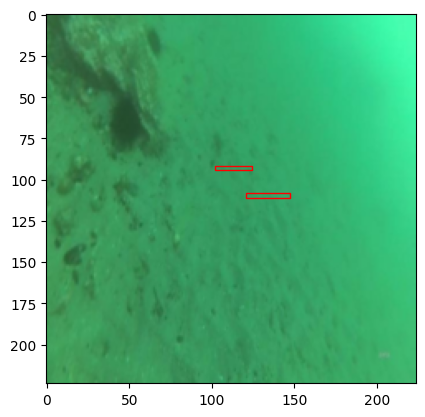

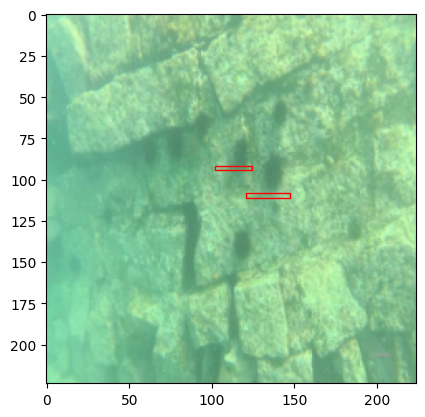

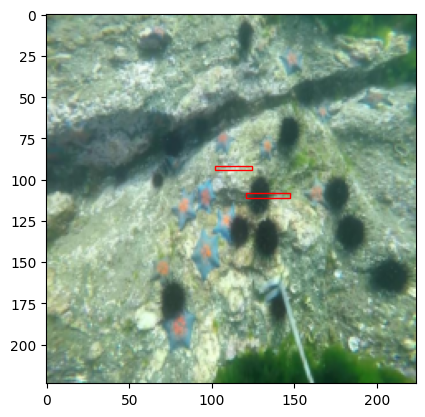

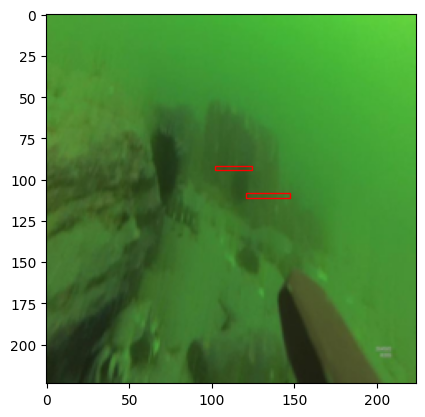

torch.Size([4, 4])
torch.Size([4, 4])
tensor([[ 1.4472,  0.7404, -4.1883, -0.9051],
        [ 1.7313,  0.8635, -4.9452, -1.1493],
        [ 1.0974,  0.4983, -3.4145, -0.4825],
        [ 2.9206, -0.4337, -7.1408, -0.9969]])
tensor([[105.4561,  79.5640,  86.4431,  77.5755],
        [125.7209,  94.8525, 103.0624,  92.4596],
        [ 80.2355,  60.5369,  65.7592,  59.0516],
        [130.5084,  98.4655, 106.9869,  95.9761]])
tensor([1.4472, 1.7313, 1.0974, 2.9206])


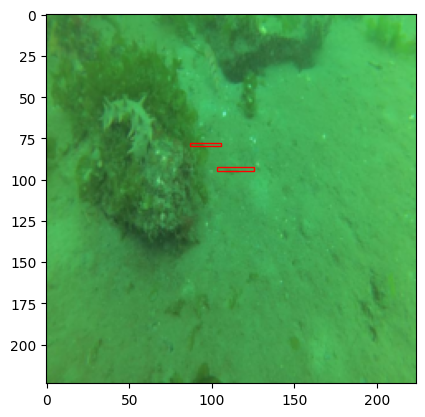

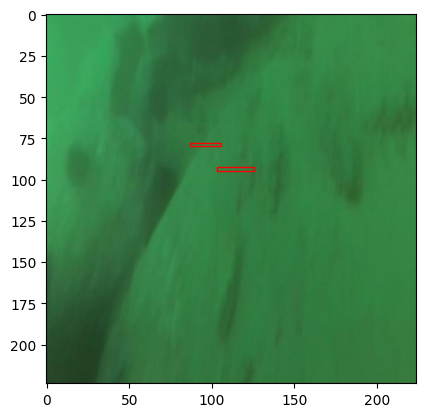

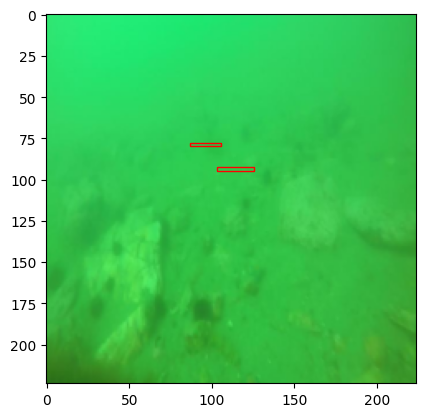

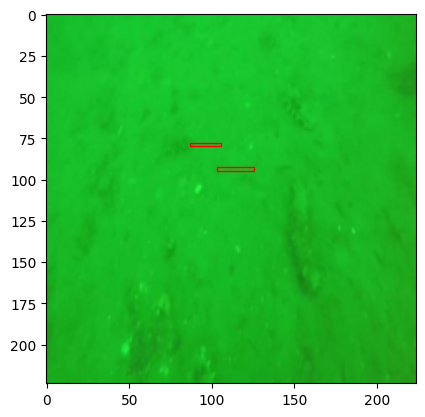

torch.Size([4, 4])
torch.Size([4, 4])
tensor([[ 2.3573,  0.8934, -5.8091, -1.5240],
        [ 2.5226,  0.8964, -6.0056, -1.6075],
        [ 2.2725,  0.9328, -5.8216, -1.5005],
        [ 1.3802,  0.8056, -4.3159, -0.8874]])
tensor([[148.4911, 112.0311, 121.7364, 109.1840],
        [153.9343, 116.1377, 126.2005, 113.1820],
        [148.7153, 112.2003, 121.9203, 109.3487],
        [108.4140,  81.7956,  88.8688,  79.7480]])
tensor([2.3573, 2.5226, 2.2725, 1.3802])


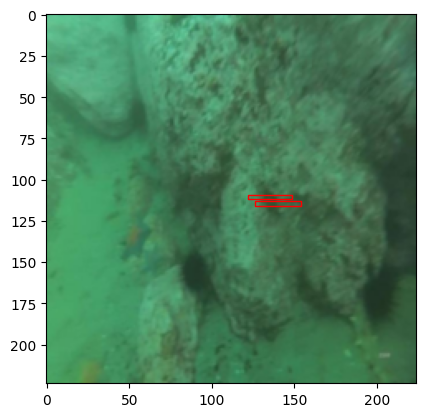

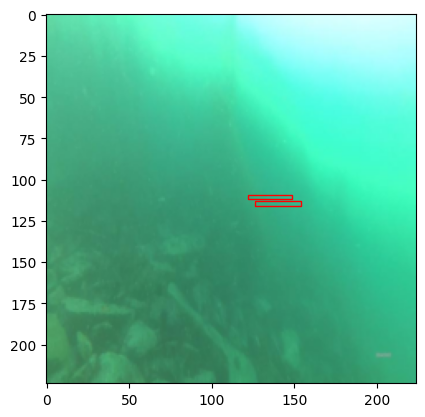

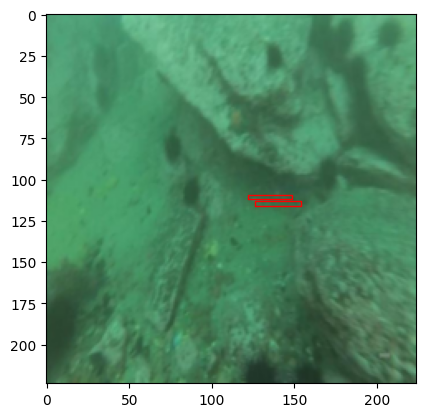

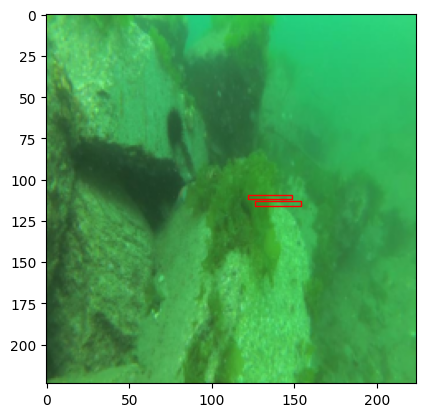

torch.Size([4, 4])
torch.Size([4, 4])
tensor([[ 2.3609,  1.0155, -6.2714, -1.5844],
        [ 2.1387,  0.9602, -5.7768, -1.4268],
        [ 1.3655,  0.7088, -3.8800, -0.8754],
        [ 1.1858,  0.6420, -3.5645, -0.6960]])
tensor([[160.0215, 120.7300, 131.1926, 117.6528],
        [147.6748, 111.4153, 121.0670, 108.5844],
        [ 96.9227,  73.1262,  79.4448,  71.3079],
        [ 87.2447,  65.8248,  71.5077,  64.1996]])
tensor([2.3609, 2.1387, 1.3655, 1.1858])


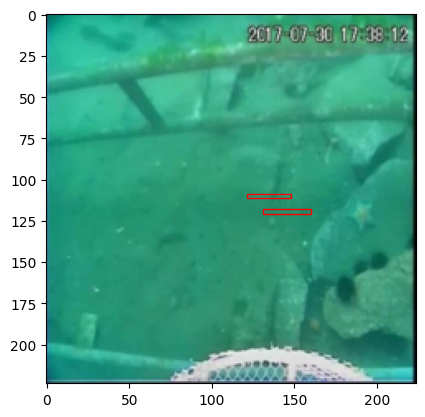

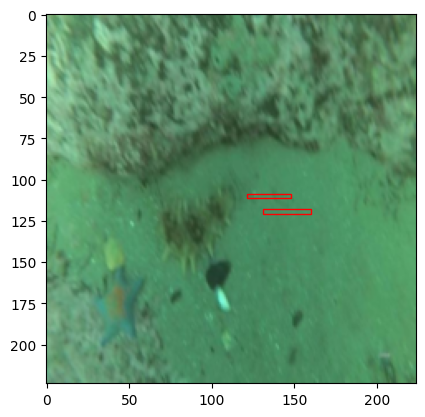

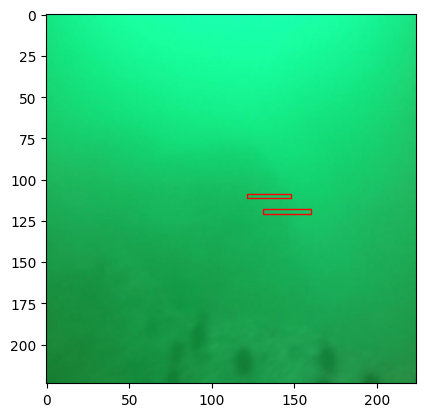

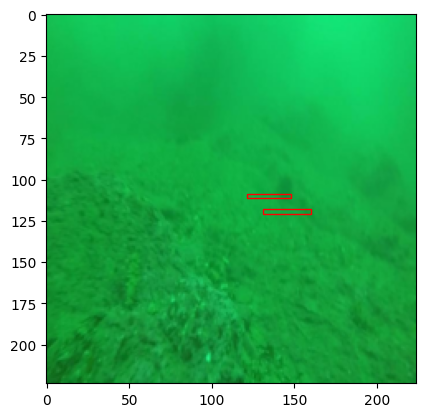

torch.Size([4, 4])
torch.Size([4, 4])
tensor([[ 2.2052,  0.8952, -5.7234, -1.4261],
        [ 1.3945,  0.7533, -4.1208, -0.8923],
        [ 1.2125,  0.5896, -3.5306, -0.6626],
        [ 1.9639,  0.9118, -5.3570, -1.3124]])
tensor([[146.3334, 110.4033, 119.9669, 107.5992],
        [103.0424,  77.7431,  84.4636,  75.8027],
        [ 86.0355,  64.9125,  70.5159,  63.3114],
        [136.7379, 103.1642, 112.0975, 100.5515]])
tensor([2.2052, 1.3945, 1.2125, 1.9639])


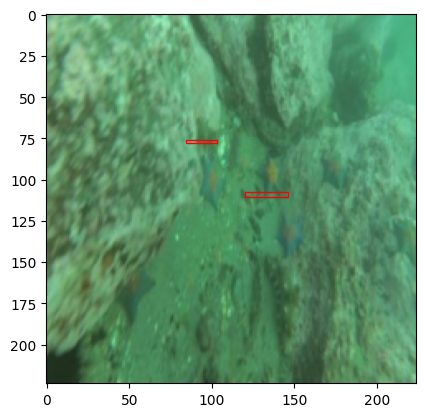

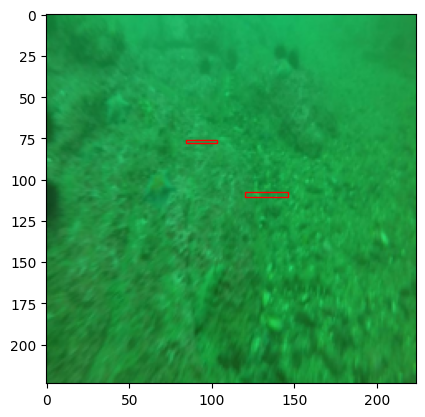

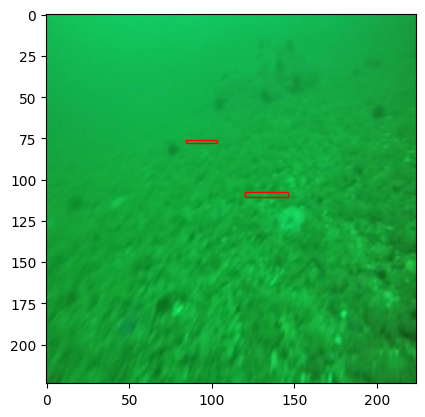

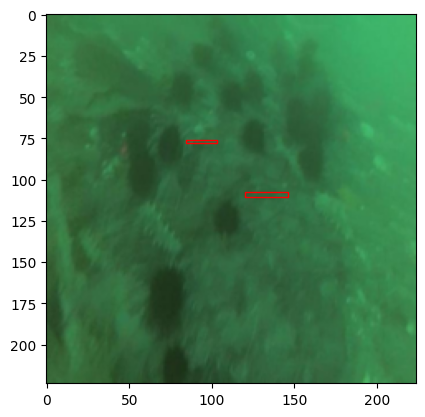

torch.Size([4, 4])
torch.Size([4, 4])
tensor([[ 1.9652,  0.8090, -5.0130, -1.2719],
        [ 2.1589,  0.8987, -5.6926, -1.4029],
        [ 2.3076,  0.7791, -5.5501, -1.4378],
        [ 1.9593,  0.8276, -5.0787, -1.2569]])
tensor([[127.9205,  96.5119, 104.8663,  94.0753],
        [146.6127, 110.6139, 120.1960, 107.8045],
        [141.5936, 106.8274, 116.0797, 104.1179],
        [129.6849,  97.8431, 106.3133,  95.3712]])
tensor([1.9652, 2.1589, 2.3076, 1.9593])


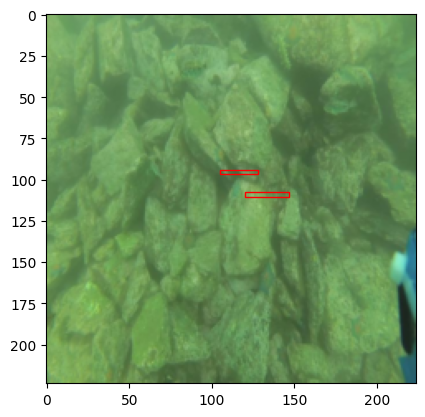

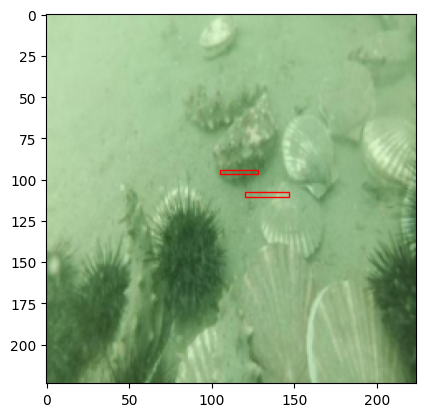

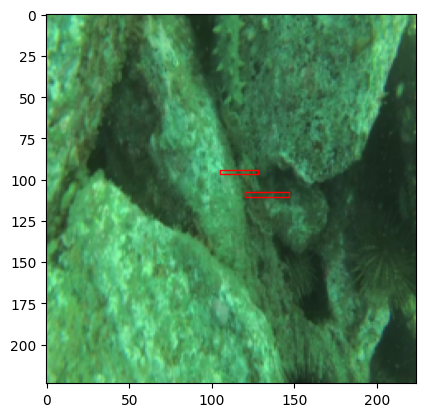

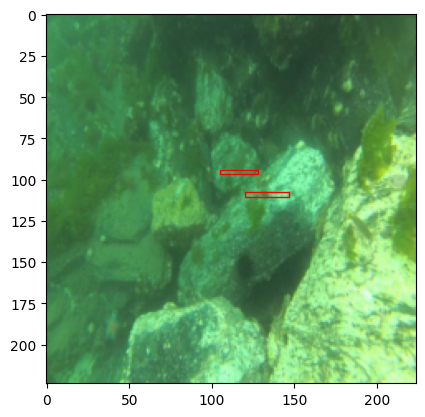

torch.Size([4, 4])
torch.Size([4, 4])
tensor([[ 1.4807,  0.8085, -4.6988, -0.9303],
        [ 1.9218,  0.7595, -4.8668, -1.2092],
        [ 1.4106,  0.7340, -3.9634, -0.9175],
        [ 2.6853,  1.0788, -7.2330, -1.7203]])
tensor([[118.0913,  89.0966,  96.8052,  86.8558],
        [123.8871,  93.4691, 101.5586,  91.1128],
        [ 98.4747,  74.2971,  80.7175,  72.4478],
        [184.9601, 139.5446, 151.6449, 135.9698]])
tensor([1.4807, 1.9218, 1.4106, 2.6853])


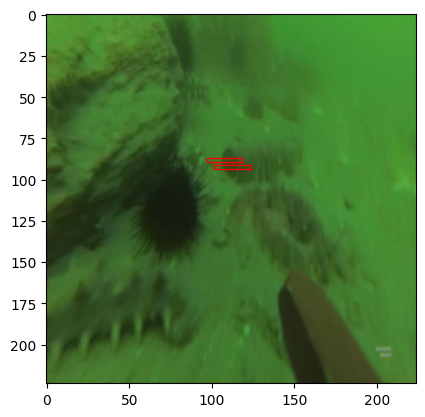

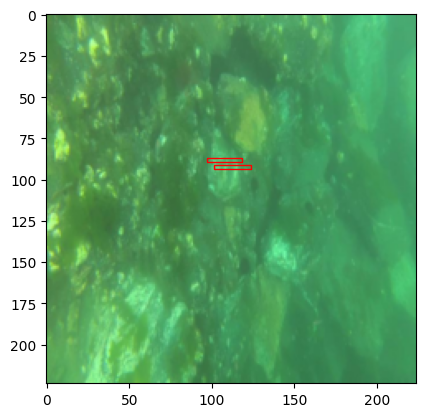

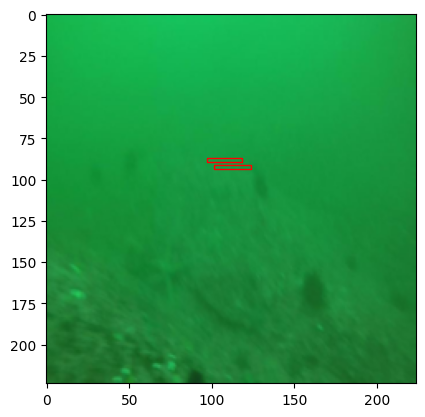

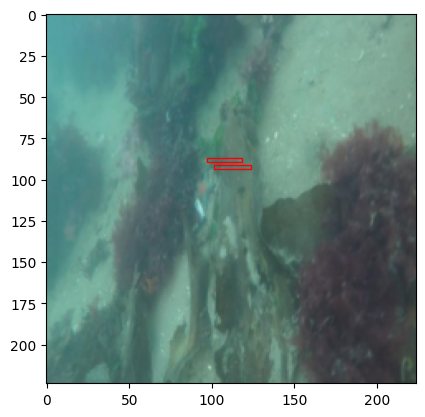

torch.Size([4, 4])
torch.Size([4, 4])
tensor([[ 2.1955,  0.9335, -5.6958, -1.4580],
        [ 1.9906,  0.9282, -5.4402, -1.3357],
        [ 2.0528,  0.9497, -5.7127, -1.3476],
        [ 1.3457,  0.7767, -4.0984, -0.8834]])
tensor([[145.6153, 109.8615, 119.3779, 107.0717],
        [139.0205, 104.8862, 113.9695, 102.2280],
        [146.0626, 110.1990, 119.7448, 107.4002],
        [102.0312,  76.9802,  83.6342,  75.0599]])
tensor([2.1955, 1.9906, 2.0528, 1.3457])


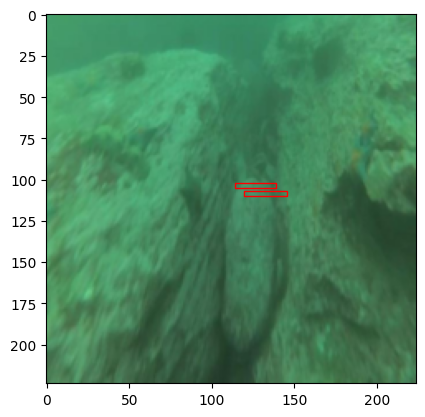

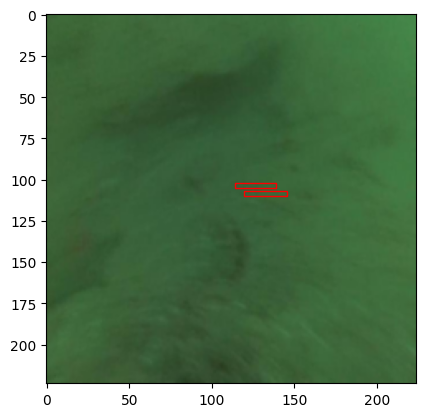

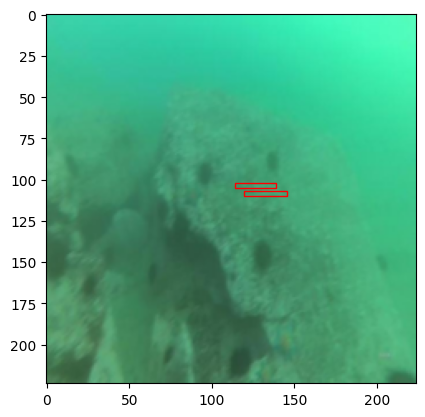

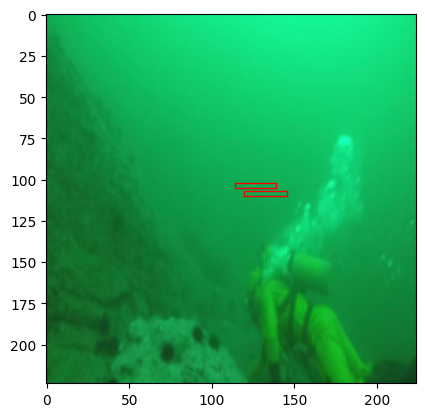

torch.Size([4, 4])
torch.Size([4, 4])
tensor([[ 1.8838,  0.9875, -5.5107, -1.2923],
        [ 1.5569,  0.7315, -4.2569, -0.9843],
        [ 1.5885,  0.7330, -4.2350, -1.0104],
        [ 1.2428,  0.7789, -3.8493, -0.8449]])
tensor([[140.6228, 106.0950, 115.2835, 103.4048],
        [106.9510,  80.6919,  87.6691,  78.6735],
        [105.8771,  79.8818,  86.7884,  77.8848],
        [ 95.6611,  72.1744,  78.4101,  70.3812]])
tensor([1.8838, 1.5569, 1.5885, 1.2428])


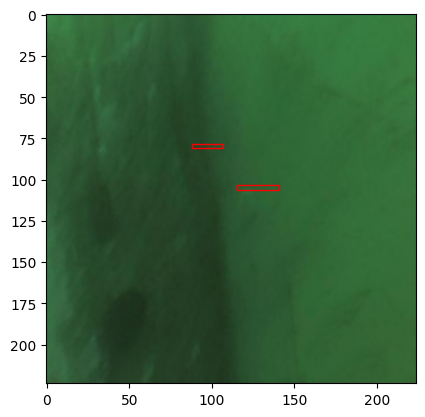

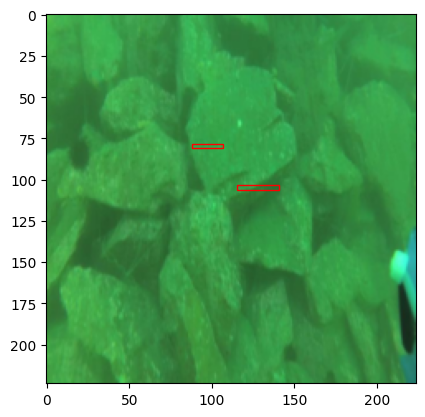

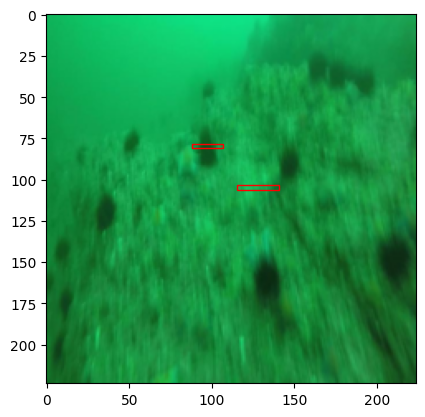

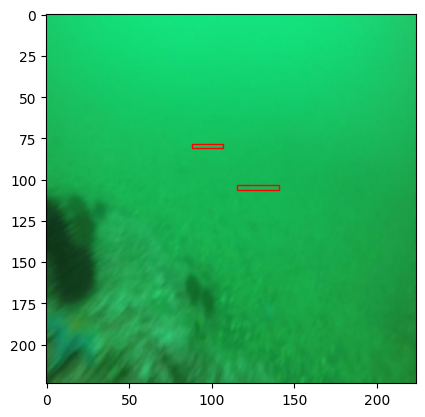

torch.Size([4, 4])
torch.Size([4, 4])
tensor([[ 1.8286,  0.8474, -4.9087, -1.2140],
        [ 2.0154,  0.6404, -4.4521, -1.2327],
        [ 1.5524,  0.6787, -4.1145, -0.9571],
        [ 1.3584,  0.7320, -4.0775, -0.8667]])
tensor([[125.0304,  94.3316, 102.4962,  91.9525],
        [112.1407,  84.6072,  91.9252,  82.4853],
        [103.4130,  78.0227,  84.7676,  76.0750],
        [101.7667,  76.7807,  83.4174,  74.8658]])
tensor([1.8286, 2.0154, 1.5524, 1.3584])


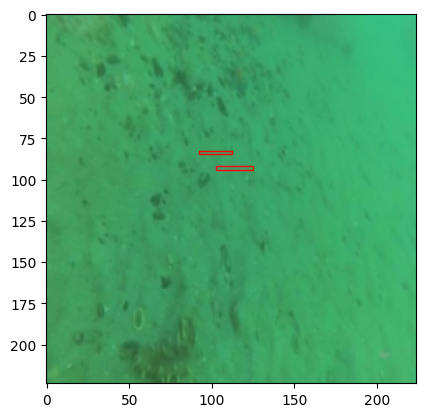

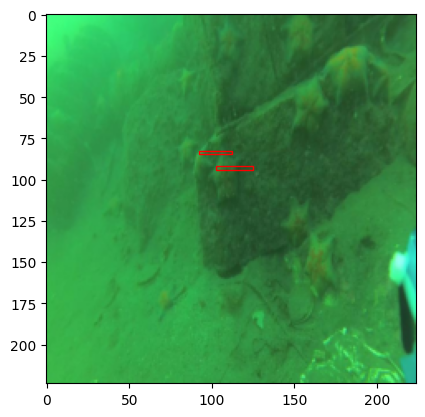

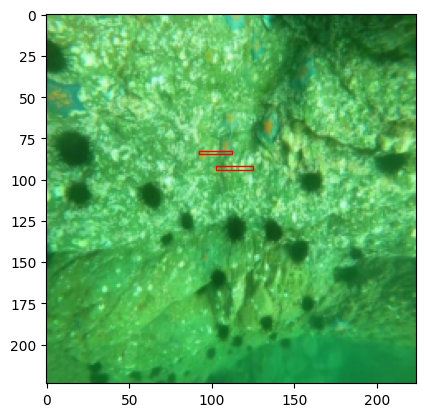

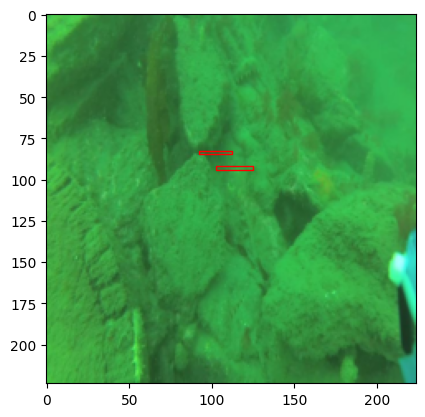

torch.Size([4, 4])
torch.Size([4, 4])
tensor([[ 1.2733,  0.5629, -3.6479, -0.6093],
        [ 2.0046,  0.8636, -5.3478, -1.2800],
        [ 2.0783,  0.8304, -5.1147, -1.3551],
        [ 1.6608,  0.7535, -4.4185, -1.0429]])
tensor([[ 86.7967,  65.4870,  71.1401,  63.8707],
        [136.5816, 103.0462, 111.9693, 100.4366],
        [130.1850,  98.2204, 106.7234,  95.7384],
        [110.8286,  83.6173,  90.8491,  81.5215]])
tensor([1.2733, 2.0046, 2.0783, 1.6608])


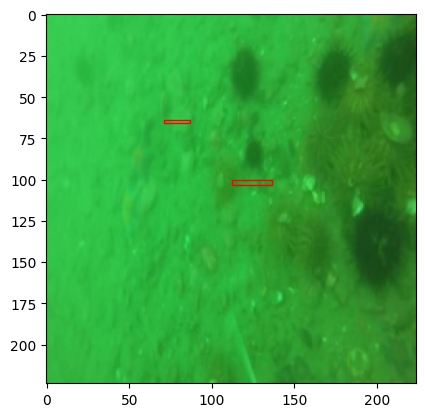

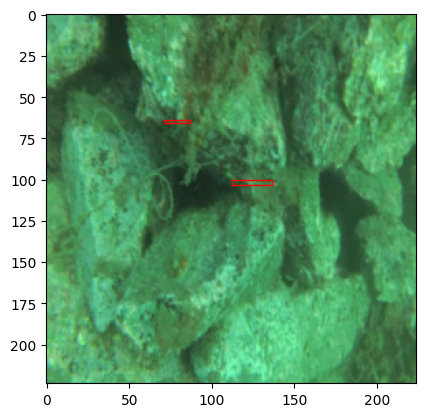

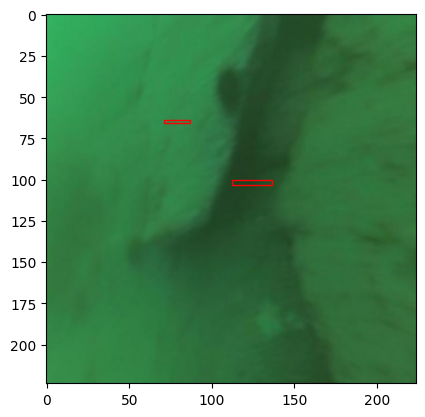

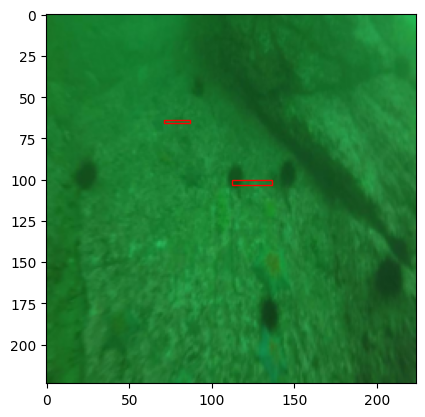

torch.Size([4, 4])
torch.Size([4, 4])
tensor([[ 2.0141,  0.9374, -5.6323, -1.3295],
        [ 1.3084,  0.6400, -3.6610, -0.7918],
        [ 2.4585,  0.3715, -6.0211, -1.2581],
        [ 1.9417,  0.9393, -5.4564, -1.3056]])
tensor([[143.9902, 108.6355, 118.0453, 105.8781],
        [ 90.1433,  68.0116,  73.8849,  66.3286],
        [142.8674, 107.7884, 117.1239, 105.0536],
        [139.3139, 105.1076, 114.2101, 102.4434]])
tensor([2.0141, 1.3084, 2.4585, 1.9417])


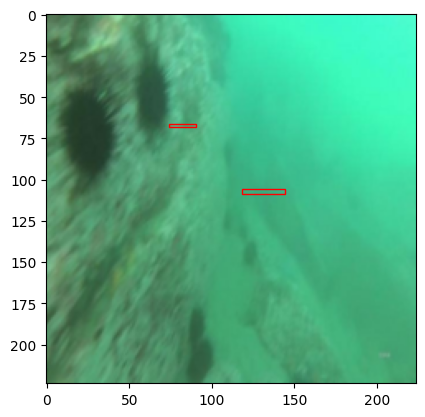

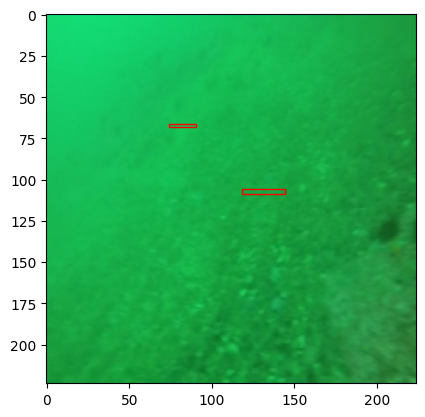

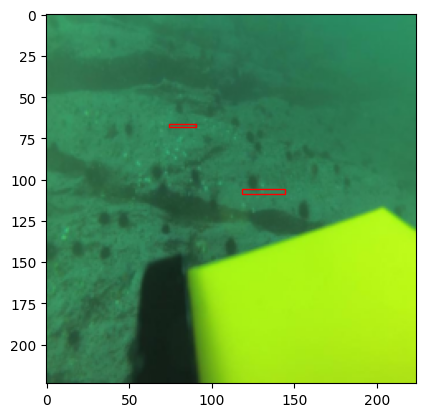

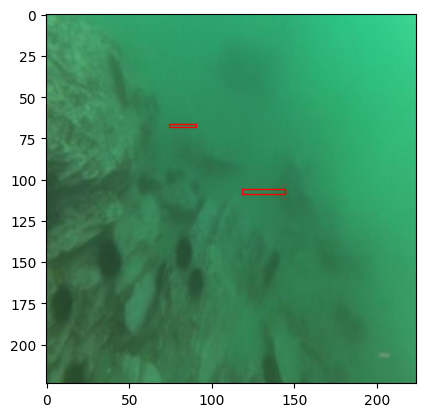

torch.Size([2, 4])
torch.Size([2, 4])
tensor([[ 2.1266,  0.9530, -5.7997, -1.4054],
        [ 2.1293,  0.9948, -5.9019, -1.4135]])
tensor([[148.1415, 111.7674, 121.4498, 108.9272],
        [150.9247, 113.8671, 123.7322, 110.9714]])
tensor([2.1266, 2.1293])


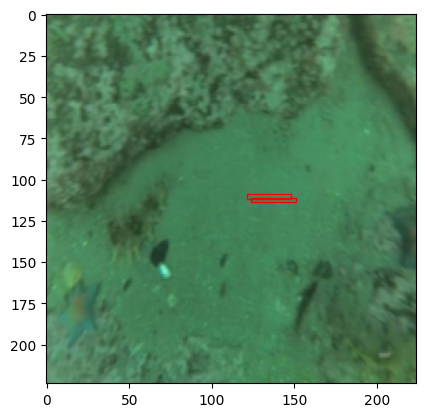

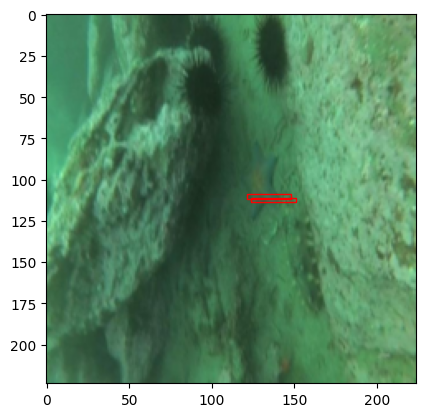

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the trained model
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

# Iterate over a batch of images for visualization
for batch in data_loader:
    inputs, targets = batch

    with torch.no_grad():
        class_scores, bounding_boxes = model(inputs)

    print(class_scores.shape)
    print(bounding_boxes.shape)
    print(class_scores)
    print(bounding_boxes)

    max_scores, max_indices = torch.max(class_scores, dim=1)

# Use max_scores as the final class scores
    final_class_scores = max_scores
    print(final_class_scores)


    # Assuming you have a function for NMS
    keep = nms(bounding_boxes, final_class_scores, iou_threshold=0.5)
    final_class_scores = class_scores.view(-1)[keep]
    final_bounding_boxes = bounding_boxes.view(-1, 4)[keep]

    # Visualize the results for each image in the batch
    for i in range(len(inputs)):
        image = inputs[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array
        fig, ax = plt.subplots(1)
        ax.imshow(image)

        for box, score in zip(final_bounding_boxes, final_class_scores):
            # Check if the score is above a certain threshold (adjust as needed)
            if score > 0.5:
                rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                         linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

        plt.show()
